<a href="https://colab.research.google.com/github/lIIIIllIIllll/AI_lab/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
try:
    import torch
    print("✓ PyTorch is successfully imported!")
    print(f"PyTorch version: {torch.__version__}")

    if torch.cuda.is_available():
        print(f"✓ CUDA is available! Device count: {torch.cuda.device_count()}")
        print(f"Current CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA is not available. Using CPU.")

    test_tensor = torch.tensor([1, 2, 3, 4, 5])
    print(f"✓ Test tensor created: {test_tensor}")
    print(f"Tensor shape: {test_tensor.shape}")
    print(f"Tensor device: {test_tensor.device}")

    squared_tensor = test_tensor ** 2
    print(f"✓ Basic operation test (squaring): {squared_tensor}")

    print("\n🎉 PyTorch is working correctly!")

except ImportError as e:
    print("❌ PyTorch is not installed or not available")
    print(f"Error details: {e}")
    print("Please install PyTorch using: pip install torch")

except Exception as e:
    print(f"❌ An error occurred while testing PyTorch: {e}")

✓ PyTorch is successfully imported!
PyTorch version: 2.8.0+cu126
✓ CUDA is available! Device count: 1
Current CUDA device: Tesla T4
✓ Test tensor created: tensor([1, 2, 3, 4, 5])
Tensor shape: torch.Size([5])
Tensor device: cpu
✓ Basic operation test (squaring): tensor([ 1,  4,  9, 16, 25])

🎉 PyTorch is working correctly!


In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.8.0+cu126
2.8.0+cu126


**Preparation**

In [35]:
!pip install librosa

In [36]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

def plot_waveform(waveform, sr, title="Waveform", ax = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sr

  if ax is None:
    _, ax = plt.subplots(1, 1)
  ax.plot(time_axis, waveform[0], linewidth = 1)
  ax.grid(True)
  ax.set_xlim([0, time_axis[-1]])
  ax.set_title(title)

def plot_spectrogram(specgram, title = None, ylabel = "freq_bin", ax = None):
  if ax is None:
    _, ax = plt.subplots(1,1)
  if title is not None:
    ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation = "nearest")

def plot_fbank(fbank, title = None):
  fig, axs = plt.subplots(1,1)
  axs.set_title(title or "Filter bank")
  axs.imshow(fbank, aspect="auto")
  axs.set_ylabel("frequency bin")
  axs.set_xlabel("mel bin")

/tmp/ipython-input-3381063616.py:7: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


**Spectrogram**

In [37]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

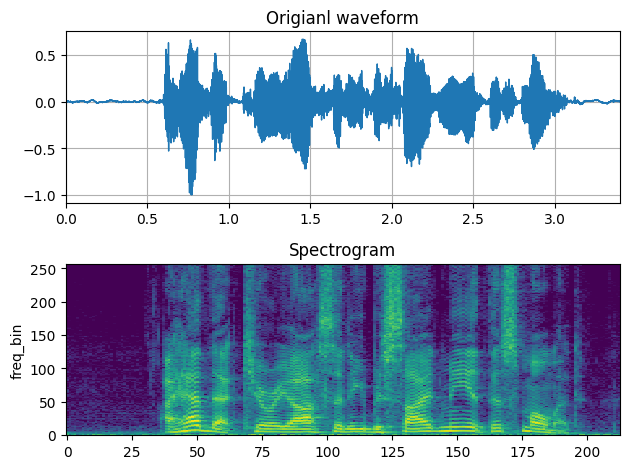

In [38]:
fig, axs = plt.subplots(2,1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Origianl waveform", ax = axs[0])
plot_spectrogram(spec[0], title = "Spectrogram", ax = axs[1])
fig.tight_layout()

**The effect of n_fft parameter**

In [39]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
  spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
  spec = spectrogram(SPEECH_WAVEFORM)
  specs.append(spec)

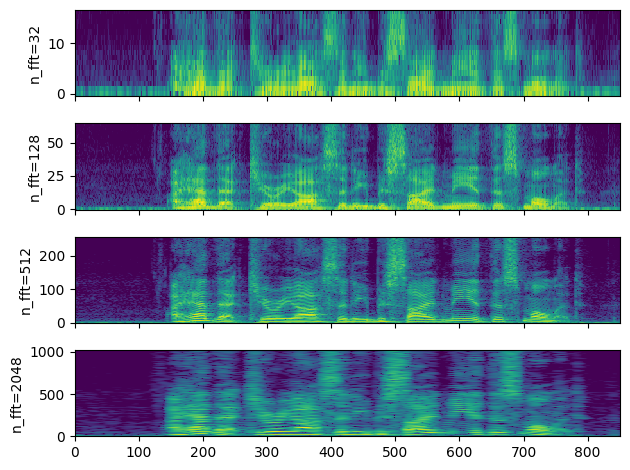

In [40]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
  plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax = axs[i])
  axs[1].set_xlabel(None)
fig.tight_layout()

In [41]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)

# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [42]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

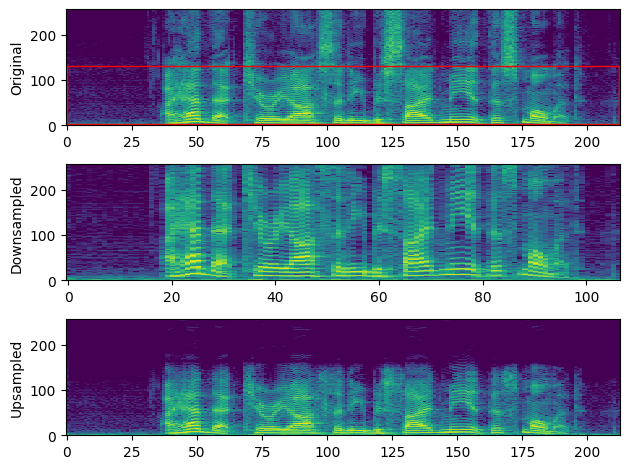

In [43]:
# Visualize it
fig, axs = plt.subplots(3,1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0,3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

**GriffinLim**

In [44]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft = n_fft)
griffinlim = T.GriffinLim(n_fft = n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffinlim(spec)

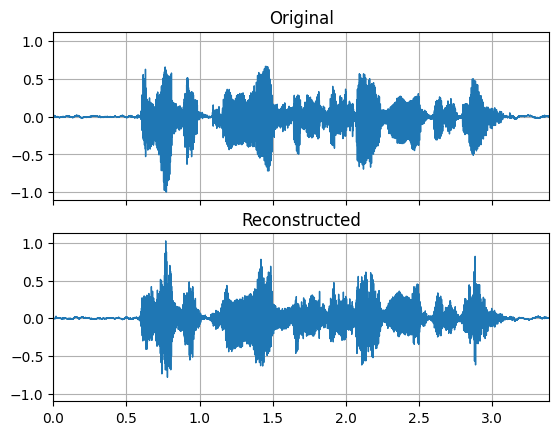

In [45]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title = "Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title = "Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

**Mel Filter Bank**

In [47]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels = n_mels,
    f_min = 0.0,
    f_max = sample_rate / 2.0,
    sample_rate = sample_rate,
    norm = "slaney",
)

NameError: name 'F' is not defined

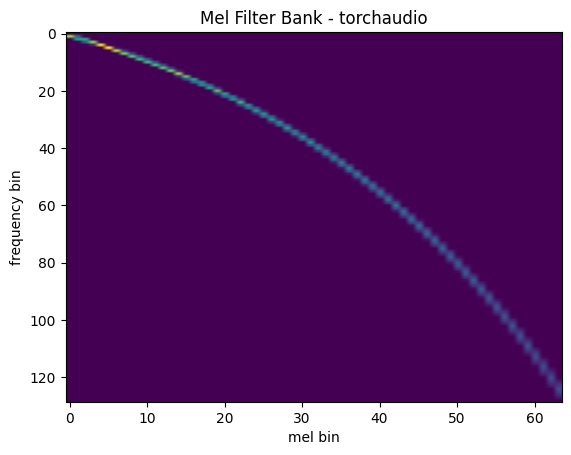

In [ ]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

**Comparison against librosa**

In [ ]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

Mean Square Difference:  3.934872696751886e-17


/tmp/ipython-input-607204609.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mel_filters - mel_filters_librosa).mean().item()


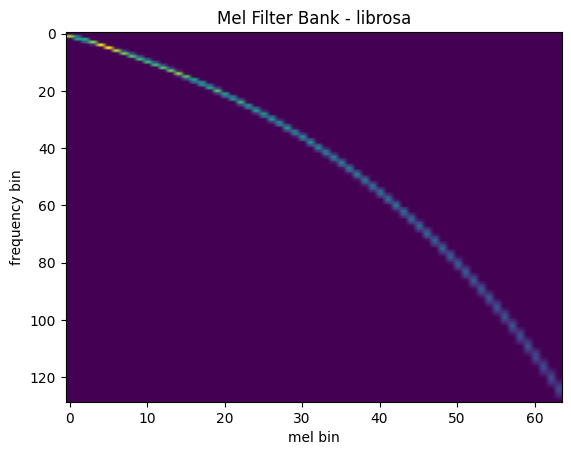

In [ ]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

**MelSpectrogram**



In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

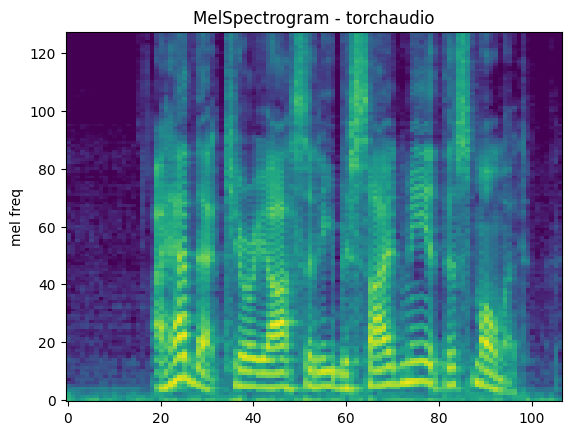

In [ ]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

**Comparison against librosa**

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.2873604404717298e-09


/tmp/ipython-input-2206006589.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(melspec - melspec_librosa).mean().item()


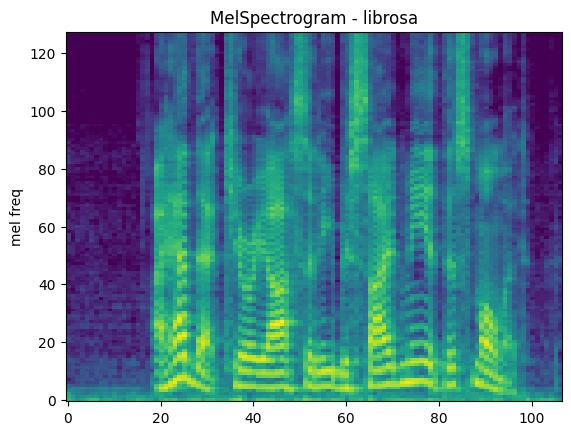

In [ ]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

**MFCC**

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

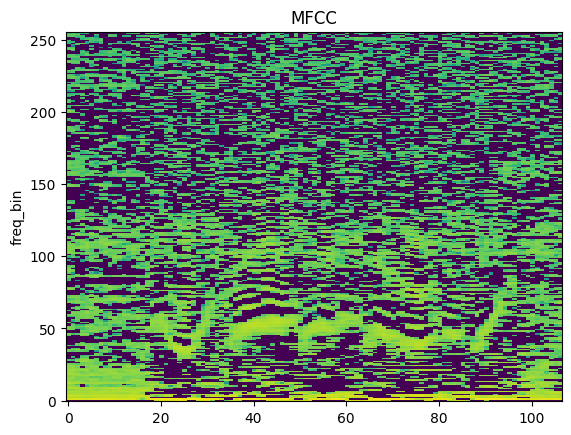

In [ ]:
plot_spectrogram(mfcc[0], title="MFCC")

**Comparison against librosa**

In [ ]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

NameError: name 'mfcc' is not defined

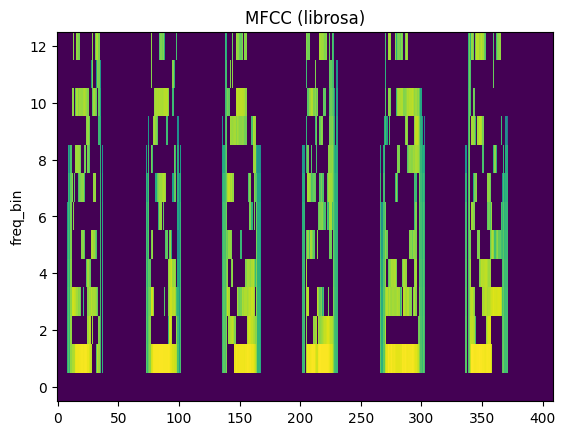

In [32]:
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

**LFCC**

In [31]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")

NameError: name 'SPEECH_WAVEFORM' is not defined

**Pitch**

In [ ]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

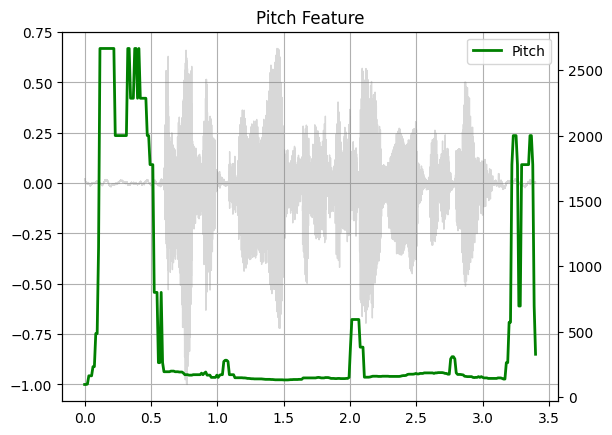

In [ ]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

**Assignment**

In [12]:
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/AI_HW/test_audio.mp3"
waveform, sr_torch = torchaudio.load(file_path)
y, sr_librosa = librosa.load(file_path, sr=sr_torch)

print("Waveform shape:", waveform.shape)
print("Sample Rate:", sr_torch)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Waveform shape: torch.Size([1, 209088])
Sample Rate: 24000


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

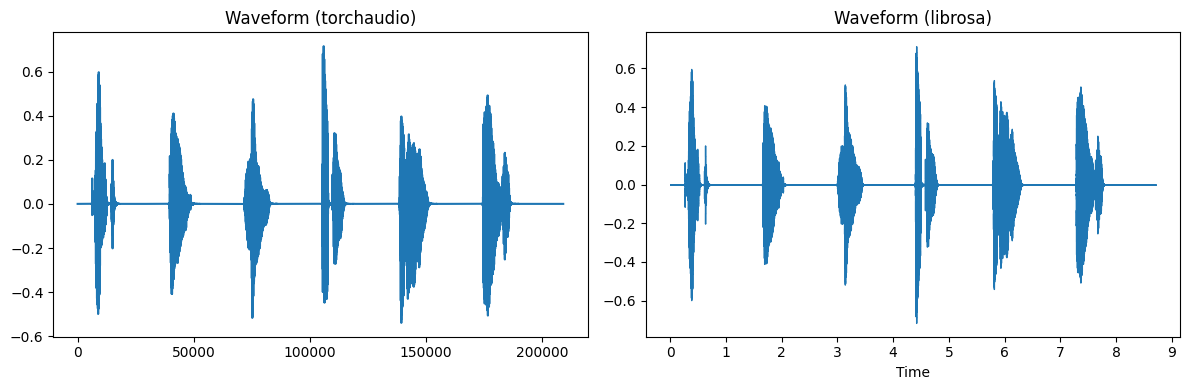

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform.t().numpy())
plt.title("Waveform (torchaudio)")

plt.subplot(1, 2, 2)
librosa.display.waveshow(y, sr=sr_librosa)
plt.title("Waveform (librosa)")

plt.tight_layout()
plt.show()

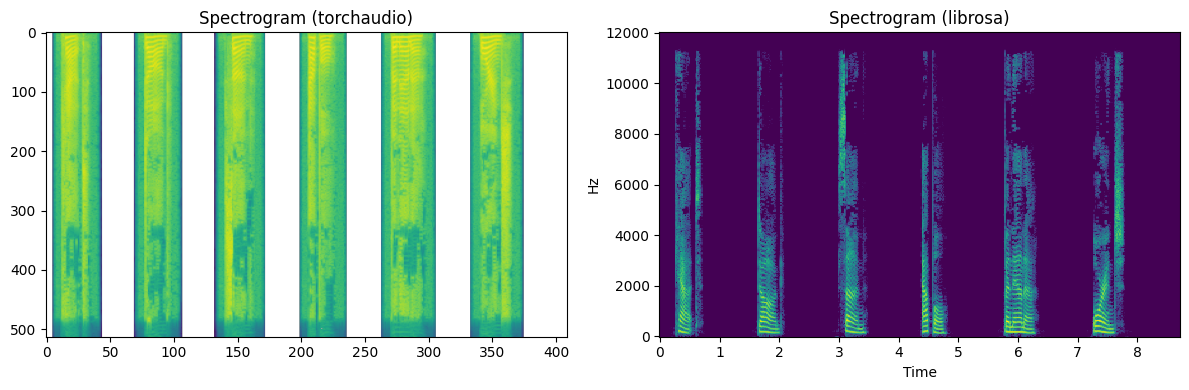

In [26]:
spec_torch = T.Spectrogram(n_fft=1024, hop_length=512)(waveform)
spec_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
spec_librosa_db = librosa.amplitude_to_db(np.abs(spec_librosa))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(spec_torch.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title("Spectrogram (torchaudio)")

plt.subplot(1, 2, 2)
librosa.display.specshow(spec_librosa_db, sr=sr_librosa, hop_length=512, x_axis='time', y_axis='linear', cmap='viridis')
plt.title("Spectrogram (librosa)")

plt.tight_layout()
plt.show()


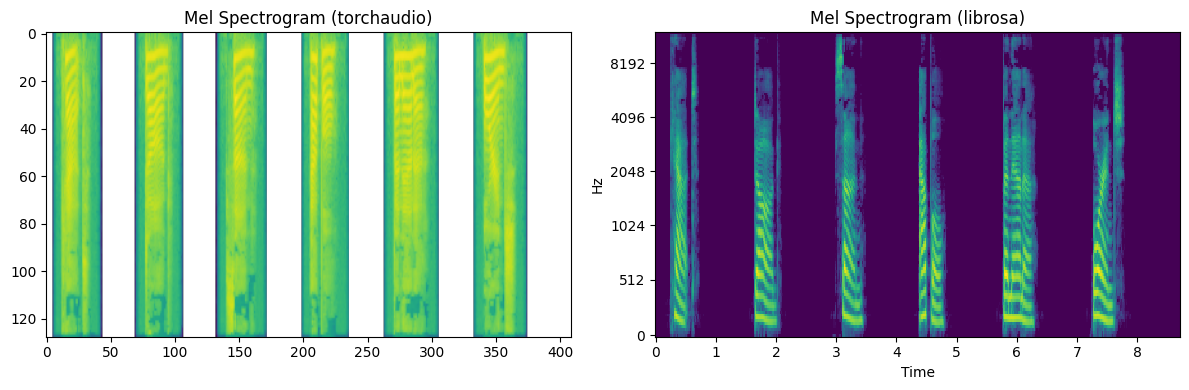

In [16]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_torch = T.MelSpectrogram(
    sample_rate=sr_torch,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)(waveform)

mel_librosa = librosa.feature.melspectrogram(y=y, sr=sr_librosa,
                                             n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_librosa_db = librosa.power_to_db(mel_librosa, ref=np.max)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel_torch.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title("Mel Spectrogram (torchaudio)")

plt.subplot(1, 2, 2)
librosa.display.specshow(mel_librosa_db, sr=sr_librosa, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='viridis')
plt.title("Mel Spectrogram (librosa)")

plt.tight_layout()
plt.show()


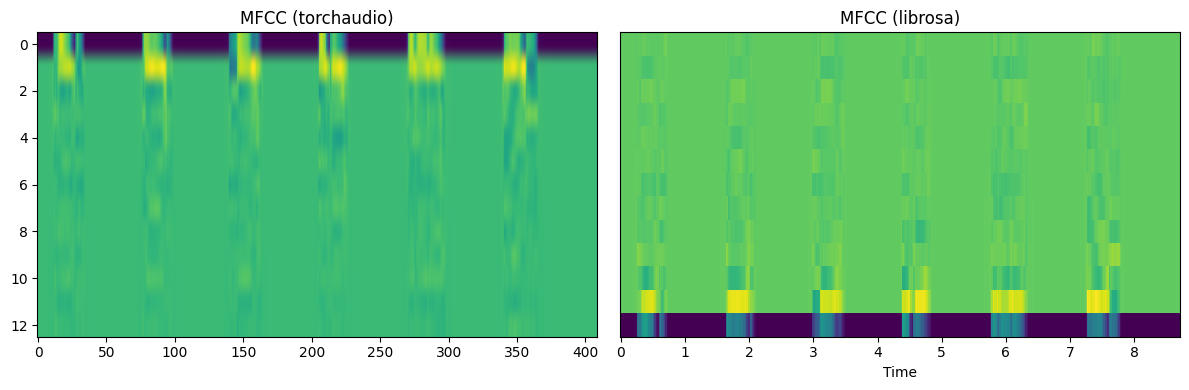

In [17]:
mfcc_torch = T.MFCC(
    sample_rate=sr_torch, n_mfcc=13,
    melkwargs={"n_fft":1024, "hop_length":512, "n_mels":23}
)(waveform)

mfcc_librosa = librosa.feature.mfcc(y=y, sr=sr_librosa, n_mfcc=13, n_fft=1024, hop_length=512)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mfcc_torch[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title("MFCC (torchaudio)")

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_librosa, x_axis='time', sr=sr_librosa, hop_length=512, cmap='viridis')
plt.title("MFCC (librosa)")

plt.tight_layout()
plt.show()


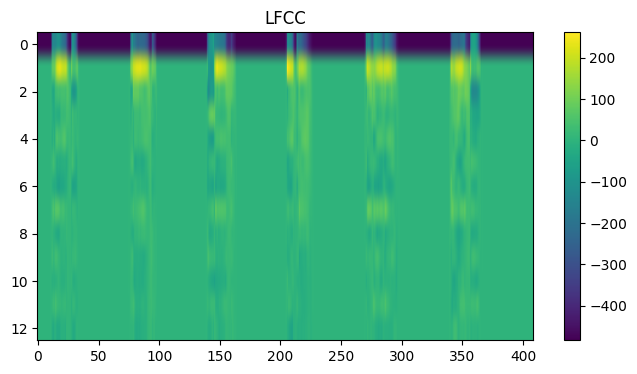

In [23]:
lfcc_torch = T.LFCC(
    sample_rate=sr_torch, n_lfcc=13,
    speckwargs={"n_fft":1024, "hop_length":512}
)(waveform)

plt.figure(figsize=(8, 4))
plt.imshow(lfcc_torch[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title("LFCC")
plt.colorbar()
plt.show()